In [1]:
%pylab inline
import pandas as pd

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

Populating the interactive namespace from numpy and matplotlib


In [2]:
results = pd.read_csv('final_results_43.csv', index_col=0)
ms_results = pd.read_csv('MS_results_43.csv', index_col=0)
sample_info = pd.read_csv('sample_info_43.csv', index_col=0)

df = pd.read_csv('exp_mat_43.csv', index_col=0)
df.columns = df.columns.map(int)

In [3]:
import NaiveDE
dfm = NaiveDE.stabilize(df.T).T
res = NaiveDE.regress_out(sample_info, dfm, 'np.log(total_count)').T

In [4]:
import SpatialDE

In [5]:
g = "'foxj1'"
X = sample_info[['x', 'y']]
Y = res[g][:, None]
Y -= Y.mean(0)  # Make more interpretable scale for plotting

In [6]:
def linear_kernel_pred(X1, X2):
    X1_ = X1 - X1.mean(0)
    X2_ = X2 - X2.mean(0)
    K = np.dot(X1, X2.T)
    return K / K.max()

In [7]:
K_l = SpatialDE.base.linear_kernel(X)

In [8]:
n = K_l.shape[0]
U, S = SpatialDE.base.factor(K_l)
UT1 = SpatialDE.base.get_UT1(U)
UTy = SpatialDE.base.get_UTy(U, Y[:, 0])

max_ll, max_delta, max_mu_hat, max_s2_t_hat, s2_logdelta = \
SpatialDE.base.lbfgsb_max_LL(UTy, UT1, S, n)

In [9]:
def cosine_kernel_pred(X1, X2, p):
    X1sq = np.sum(np.square(X1), 1)
    X2sq = np.sum(np.square(X2), 1)
    R2 = -2. * np.dot(X1, X2.T) + (X1sq[:, None] + X2sq[None, :])
    R2 = np.clip(R2, 1e-12, np.inf)
    
    return np.cos(2 * np.pi * np.sqrt(R2) / p)

In [10]:
p = ms_results.iloc[12]['l']

In [11]:
K_p = SpatialDE.base.cosine_kernel(X, p)

In [12]:
def make_sliver(sample_info, b=30., a=1., oo=35):
    xx = np.linspace(0, sample_info.x.max())
    yy = b + a * xx
    
    sliver = sample_info.query('y - @oo < @b + @a * x < y + @oo')
    
    return sliver, xx, yy

In [13]:
def plot_sliver(sample_info, sliver, xx, yy):
    plt.scatter(sample_info.x, sample_info.y, c='lightgrey')
    plt.scatter(sliver.x, sliver.y, c='k')
    plt.plot(xx, yy, c='tab:red')
    plt.axis('equal');
    plt.gca().invert_yaxis()
    plt.xlabel('x (µm)')
    plt.ylabel('y (µm)');

In [14]:
def predict_gp(X_new, Y, K, K_s, s2, delta):
    Y_new = K_s.dot(np.linalg.solve(s2 * K + s2 * delta * np.eye(K.shape[0]), Y))
    return Y_new

In [15]:
def plot_sliver_expr(sample_info, sliver, Ys):
    plt.scatter(X.x, Ys, c='lightgrey')
    plt.scatter(sliver.x, Ys.loc[sliver.index], c='k');

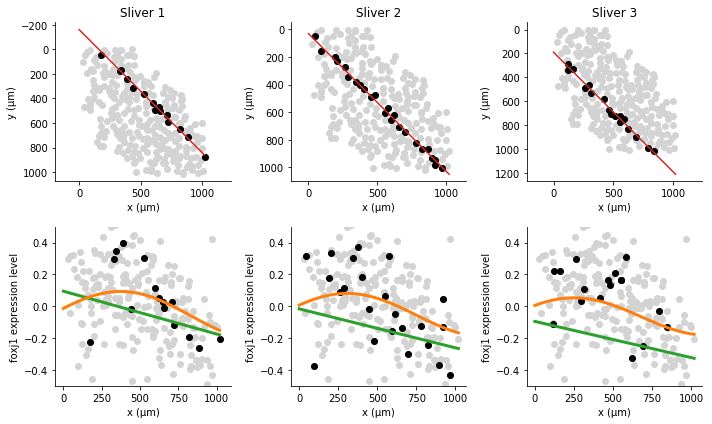

In [16]:
figsize(10, 6)

for i, b in enumerate([-160, 30, 190]):
    ## Sliver in 2D context

    plt.subplot(2, 3, i + 1)

    sliver, xx, yy = make_sliver(sample_info, b)
    plot_sliver(sample_info, sliver, xx, yy)
    plt.title('Sliver {}'.format(i + 1))
    
    plt.subplot(2, 3, i + 1 + 3)
    
    ## Sliver in expression context

    X_new = np.vstack((xx, yy)).T
    
    plot_sliver_expr(sample_info, sliver, res[g])
    
    ## Linear model
    
    mu = max_mu_hat
    s2 = max_s2_t_hat
    delta = max_delta
    
    K_l_s = linear_kernel_pred(X_new, X)
    
    Y_new = predict_gp(X_new, Y, K_l, K_l_s, s2, delta)
    
    plt.plot(X_new[:, 0], Y_new, c='C2', lw=3)
    
    ## periodic model
    
    mu = ms_results.iloc[12]['max_mu_hat']
    s2 = ms_results.iloc[12]['max_s2_t_hat']
    delta = ms_results.iloc[12]['max_delta']
    
    K_p_s = cosine_kernel_pred(X_new, X, p)
    
    Y_new = predict_gp(X_new, Y, K_p, K_p_s, s2, delta)
    
    plt.plot(X_new[:, 0], Y_new, c='C1', lw=3)
    
    ## Labels etc
    
    plt.ylim(-0.5, 0.5);
    plt.xlabel('x (µm)')
    plt.ylabel('foxj1 expression level');
    
plt.tight_layout()